<a href="https://colab.research.google.com/github/NoemiRyf/ML2_Project/blob/main/Trash_Sorting_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision**

Import necessary libraries 

In [17]:
import os
import numpy as np
import shutil
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.applications as keras_applications

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dropout
from keras.regularizers import l2


**Data Collection**

In [ ]:
%cd /content/drive/MyDrive/ML2_Project/data


/content/drive/MyDrive/ML2_Project/data


Extract the dataset-resized ZIP file

In [50]:
zip_path = '/content/drive/MyDrive/ML2_Project/data/dataset-resized.zip'
destination_folder = '/content/drive/MyDrive/ML2_Project/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


Run resize.py to resizing images in different categories and saving them

In [ ]:
!python resize.py

**Data Preperation**

Define image data generator for training and validation data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

Load dataset

In [ ]:
dataset_dir = '/content/drive/MyDrive/ML2_Project/data/dataset-resized'

Get the list of subdirectories (classes) in the dataset directory

In [ ]:
classes = sorted(os.listdir(dataset_dir))

Create the list of directories for train and test sets

In [ ]:
train_dir = '/content/drive/MyDrive/ML2_Project/data/train'
test_dir = '/content/drive/MyDrive/ML2_Project/data/test'

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

Data split and directory creation

In [ ]:
# Split the dataset into training and test sets for each class
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    
    # Skip if it's not a directory
    if not os.path.isdir(class_dir):
        continue
    
    files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))]
    labels = [class_name] * len(files)  # Assign the class label to each file
    
    train_files, test_files, train_labels, test_labels = train_test_split(files, labels, test_size=0.2, random_state=42, stratify=labels)

    # Create subdirectories for each class in train and test directories
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Move train files to train class directory
    for file in train_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(train_class_dir, file)
        shutil.copyfile(src, dst)
        
    # Move test files to test class directory
    for file in test_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(test_class_dir, file)
        shutil.copyfile(src, dst)

Data Generators

Create the generators for training and testing

In [ ]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


**Modeling**

CNN Model (not pre-trained)

Build CNN Model

In [23]:
# Define the model architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))  
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))  
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))  
cnn_model.add(Flatten())
cnn_model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(Dense(units=6, activation='softmax'))

Compile and train CNN Model

In [24]:
# optimizer = Adam(learning_rate=0.001)
# optimizer = SGD(learning_rate=0.001)

cnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
history = cnn_model.fit(train_set, epochs=25, batch_size=64, validation_data=test_set)

Epoch 1/25
64/64 [==============================] - 44s 666ms/step - loss: 2.5478 - accuracy: 0.4245 - val_loss: 3.9494 - val_accuracy: 0.2008
Epoch 2/25
64/64 [==============================] - 41s 638ms/step - loss: 1.8450 - accuracy: 0.5597 - val_loss: 5.3707 - val_accuracy: 0.1909
Epoch 3/25
64/64 [==============================] - 38s 596ms/step - loss: 1.7092 - accuracy: 0.6033 - val_loss: 3.1075 - val_accuracy: 0.2421
Epoch 4/25
64/64 [==============================] - 37s 583ms/step - loss: 1.6033 - accuracy: 0.6469 - val_loss: 3.7846 - val_accuracy: 0.2224
Epoch 5/25
64/64 [==============================] - 37s 573ms/step - loss: 1.5254 - accuracy: 0.6662 - val_loss: 3.6701 - val_accuracy: 0.2657
Epoch 6/25
64/64 [==============================] - 38s 590ms/step - loss: 1.4056 - accuracy: 0.7098 - val_loss: 3.4544 - val_accuracy: 0.3248
Epoch 7/25
64/64 [==============================] - 39s 611ms/step - loss: 1.2950 - accuracy: 0.7439 - val_loss: 3.1720 - val_accuracy: 0.3110

Resnet Model (combination pre-trained and self trained data)

In [27]:
# Load the pre-trained ResNet50 model
resnet_model = keras_applications.ResNet50(include_top=False, input_shape=(64, 64, 3), pooling='avg', weights='imagenet')

# Freeze the weights of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model architecture with additional layers
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Dense(units=256, activation='relu'))
model_resnet.add(Dropout(0.5))  
model_resnet.add(Dense(units=128, activation='relu'))
model_resnet.add(Dense(units=64, activation='relu'))  
model_resnet.add(Dense(units=6, activation='softmax'))

# Compile the model
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(train_set, epochs=25, batch_size=64, validation_data=test_set)

Epoch 1/25
64/64 [==============================] - 55s 795ms/step - loss: 1.7568 - accuracy: 0.2055 - val_loss: 1.7116 - val_accuracy: 0.2362
Epoch 2/25
64/64 [==============================] - 50s 783ms/step - loss: 1.7205 - accuracy: 0.2204 - val_loss: 1.6867 - val_accuracy: 0.2520
Epoch 3/25
64/64 [==============================] - 50s 770ms/step - loss: 1.6999 - accuracy: 0.2328 - val_loss: 1.6562 - val_accuracy: 0.2795
Epoch 4/25
64/64 [==============================] - 49s 766ms/step - loss: 1.6712 - accuracy: 0.2576 - val_loss: 1.6495 - val_accuracy: 0.3248
Epoch 5/25
64/64 [==============================] - 50s 778ms/step - loss: 1.6759 - accuracy: 0.2472 - val_loss: 1.6331 - val_accuracy: 0.2677
Epoch 6/25
64/64 [==============================] - 49s 763ms/step - loss: 1.6589 - accuracy: 0.2848 - val_loss: 1.6442 - val_accuracy: 0.2697
Epoch 7/25
64/64 [==============================] - 48s 745ms/step - loss: 1.6516 - accuracy: 0.2749 - val_loss: 1.6056 - val_accuracy: 0.3228

**Evaluation**

Evaluate the CNN model on the test data

In [26]:
test_loss, test_accuracy = cnn_model.evaluate(test_set)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

16/16 [==============================] - 3s 199ms/step - loss: 1.6633 - accuracy: 0.6358
Test Loss: 1.6633456945419312
Test Accuracy: 0.6358267664909363


CNN Visualization of Training and Validation Metrics

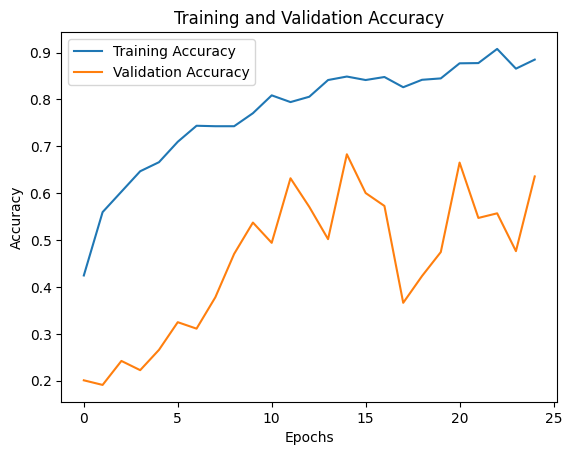

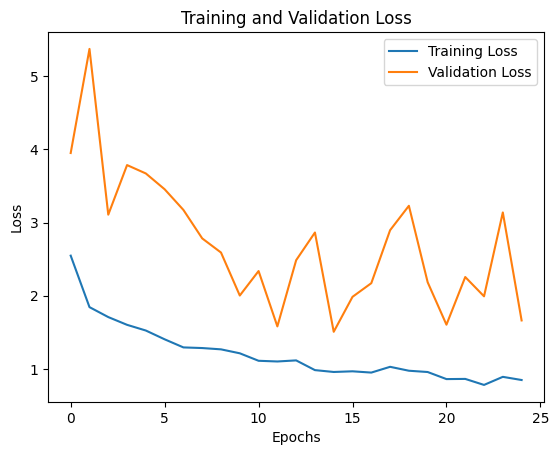

In [31]:
import matplotlib.pyplot as plt

# Get training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Get predictions for the test set
y_pred = cnn_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class indices

# Get the true labels for the test set
y_true = test_set.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("CNN Confusion Matrix:")
print(cm)

# Get classification report
class_labels = test_set.class_indices
class_names = list(class_labels.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("CNN Classification Report:")
print(report)

16/16 [==============================] - 3s 203ms/step
CNN Confusion Matrix:
[[10 14 16 21 12  8]
 [21 18 18 21 14  9]
 [18  6 13 20 17  8]
 [22 22 19 27 19 10]
 [10 15 19 23 18 12]
 [ 5  4  6  4  5  4]]
CNN Classification Report:
              precision    recall  f1-score   support

   cardboard       0.12      0.12      0.12        81
       glass       0.23      0.18      0.20       101
       metal       0.14      0.16      0.15        82
       paper       0.23      0.23      0.23       119
     plastic       0.21      0.19      0.20        97
       trash       0.08      0.14      0.10        28

    accuracy                           0.18       508
   macro avg       0.17      0.17      0.17       508
weighted avg       0.19      0.18      0.18       508



Evaluate the Resnet model on the test data

In [29]:
test_loss, test_accuracy = model_resnet.evaluate(test_set)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

16/16 [==============================] - 11s 655ms/step - loss: 1.4871 - accuracy: 0.3720
Test Loss: 1.4870764017105103
Test Accuracy: 0.3720472455024719


Resnet Visualization of Training and Validation Metrics

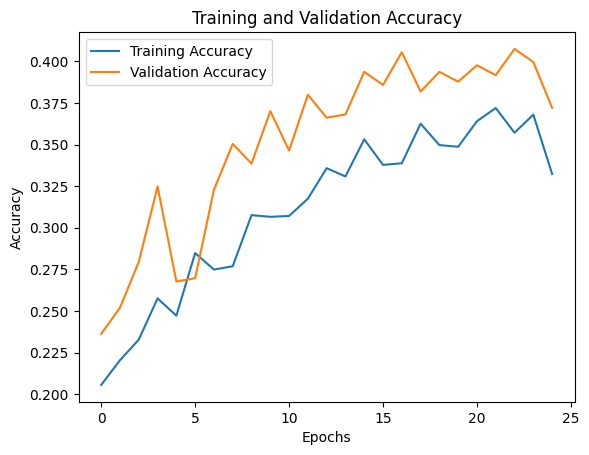

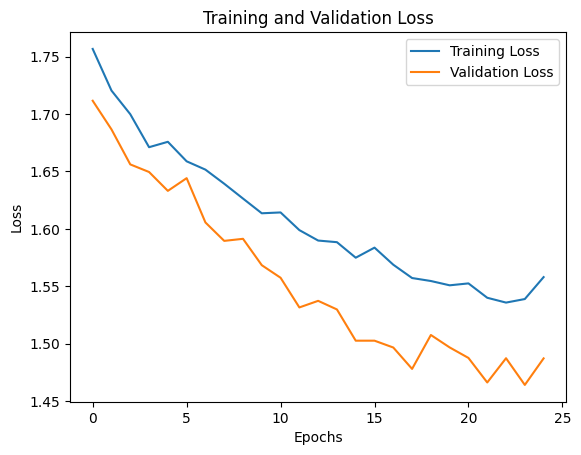

In [49]:
import matplotlib.pyplot as plt

# Get training history
accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Get predictions for the test set
y_pred = model_resnet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class indices

# Get the true labels for the test set
y_true = test_set.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Resnet Confusion Matrix:")
print(cm)

# Get classification report
class_labels = test_set.class_indices
class_names = list(class_labels.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Resnet Classification Report:")
print(report)

16/16 [==============================] - 11s 636ms/step
Resnet Confusion Matrix:
[[24 18  4 30  5  0]
 [25 24  8 38  6  0]
 [13 18 18 27  6  0]
 [28 29 13 39 10  0]
 [24 24  5 39  5  0]
 [10  7  2  8  1  0]]
Resnet Classification Report:
              precision    recall  f1-score   support

   cardboard       0.19      0.30      0.23        81
       glass       0.20      0.24      0.22       101
       metal       0.36      0.22      0.27        82
       paper       0.22      0.33      0.26       119
     plastic       0.15      0.05      0.08        97
       trash       0.00      0.00      0.00        28

    accuracy                           0.22       508
   macro avg       0.19      0.19      0.18       508
weighted avg       0.21      0.22      0.20       508



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Application**

CNN Test 1

In [45]:
from PIL import Image
import numpy as np

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/ML2_Project/data/test/glass/glass110.jpg'
test_image = Image.open(test_image_path)
target_size = (64, 64)
test_image = test_image.resize(target_size)
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predictions = cnn_model.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Map the predicted class index to the corresponding class label
class_labels = train_set.class_indices
predicted_class_label = {v: k for k, v in class_labels.items()}[predicted_class_index]

# Print the predicted class label
print('Predicted class:', predicted_class_label)


1/1 [==============================] - 0s 47ms/step
Predicted class: glass


CNN Test 2

In [42]:
from PIL import Image
import numpy as np

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/ML2_Project/data/test/plastic/plastic117.jpg'
test_image = Image.open(test_image_path)
target_size = (64, 64)
test_image = test_image.resize(target_size)
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predictions = cnn_model.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Map the predicted class index to the corresponding class label
class_labels = train_set.class_indices
predicted_class_label = {v: k for k, v in class_labels.items()}[predicted_class_index]

# Print the predicted class label
print('Predicted class:', predicted_class_label)

1/1 [==============================] - 0s 25ms/step
Predicted class: plastic


Resnet Test 1

In [43]:
from PIL import Image
import numpy as np

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/ML2_Project/data/test/glass/glass110.jpg'
test_image = Image.open(test_image_path)
target_size = (64, 64)
test_image = test_image.resize(target_size)
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predictions = model_resnet.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Map the predicted class index to the corresponding class label
class_labels = train_set.class_indices
predicted_class_label = {v: k for k, v in class_labels.items()}[predicted_class_index]

# Print the predicted class label
print('Predicted class:', predicted_class_label)

1/1 [==============================] - 0s 86ms/step
Predicted class: glass


Resnet Test 2

In [44]:
from PIL import Image
import numpy as np

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/ML2_Project/data/test/plastic/plastic117.jpg'
test_image = Image.open(test_image_path)
target_size = (64, 64)
test_image = test_image.resize(target_size)
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predictions = model_resnet.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Map the predicted class index to the corresponding class label
class_labels = train_set.class_indices
predicted_class_label = {v: k for k, v in class_labels.items()}[predicted_class_index]

# Print the predicted class label
print('Predicted class:', predicted_class_label)

1/1 [==============================] - 0s 72ms/step
Predicted class: paper


Save Models

In [51]:
cnn_model.save('/content/drive/MyDrive/ML2_Project/model/cnn_trash_classifier.h5')
model_resnet.save('/content/drive/MyDrive/ML2_Project/model/resnet_trash_classifier.h5')